In [217]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import os
import os.path
import math
from surprise import (Reader, Dataset, NormalPredictor, BaselineOnly,
                      accuracy, SVD, SVDpp, NMF, KNNBasic, KNNWithMeans,
                      KNNWithZScore, KNNBaseline)
from surprise.model_selection import (cross_validate, KFold,
                                      train_test_split, GridSearchCV,
                                      RandomizedSearchCV)

# Always make it pretty.
plt.style.use('ggplot')
%matplotlib inline
sns.set_style(style="whitegrid")

In [218]:
# Load Data
business_df = pd.read_csv('../datasets/filter_data/tucson_business.csv')
review_df = pd.read_csv('../datasets/filter_data/tucson_reviews.csv')
user_df = pd.read_csv('../datasets/filter_data/tucson_users.csv')
tucson_df=pd.read_csv('../datasets/filter_data/tucson_df.csv')
all_df= pd.read_csv('../datasets/filter_data/all_df.csv')

In [219]:
# Drop unneeded columns for users
user_df.drop(columns=['useful', 'funny', 'cool', 'fans', 'elite',
                      'friends', 'compliment_hot', 'compliment_more',
                      'compliment_profile', 'compliment_cute',
                      'compliment_list', 'compliment_note',
                      'compliment_plain', 'compliment_cool',
                      'compliment_funny', 'compliment_writer',
                      'compliment_photos'],
             axis=1, inplace=True)

In [220]:
# Drop unneeded columns for businesses
business_df.drop(columns=['address', 'postal_code', 'latitude', 'longitude',
                          'attributes', 'hours'],
                 axis=1, inplace=True)

In [221]:
# Drop unneeded columns for reviews
review_df.drop(columns=['useful', 'funny', 'cool'], axis=1, inplace=True)

In [222]:
# Look at the shapes of dataframes after removing columns
print(business_df.shape)
print(user_df.shape)
print(review_df.shape)

(702, 8)
(68783, 5)
(191113, 6)


In [223]:
# Rename columns to avoid mix-ups
review_df.rename(columns={'stars': 'review_stars'}, inplace=True)
business_df.rename(columns={'stars': 'business_stars',
                            'name': 'business_name'}, inplace=True)
user_df.rename(columns={'name': 'user_name'}, inplace=True)

In [224]:
# Create a utility matrix of user ids, business ids, and reviews
utility = tucson_df[['user_id', 'business_id', 'review_stars']]
utility.head()

,user_id,business_id,review_stars
0,4Uh27DgGzsp6PqrH913giQ,otQS34_MymijPTdNBoBdCw,4
1,4Uh27DgGzsp6PqrH913giQ,RhuYqAT45uIR2NNdDsolXQ,3
2,4Uh27DgGzsp6PqrH913giQ,RhuYqAT45uIR2NNdDsolXQ,4
3,4Uh27DgGzsp6PqrH913giQ,8QJTzIaR5FceGds8HBSIig,4
4,4Uh27DgGzsp6PqrH913giQ,Y3ZCO17N1_T_Ms1JmswwzA,4


<AxesSubplot:>

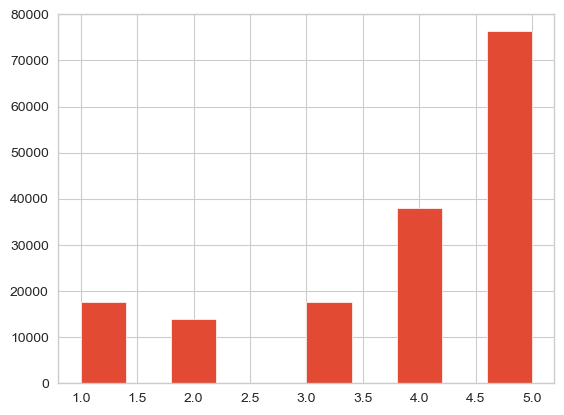

In [225]:
utility['review_stars'].hist()

In [226]:
# Prepare data to run models
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(utility, reader)
trainset, testset = train_test_split(data, test_size=0.2)

In [227]:
# Looking at the trainset in a dataframe
iterator = trainset.all_ratings()
trainset_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in iterator:
    trainset_df.loc[i] = [uid, iid, rating]
    i = i+1

trainset_df.head(2)

,uid,iid,rating
0,0.0,0.0,4.0
1,0.0,238.0,4.0


In [228]:
def inner_to_raw_iid(row):
    '''
    Returns the raw item id associated with a given Surprise inner id
    
    Parameters:
    row: corresponds to a row in a dataframe
    
    Returns:
    output (float): raw item id
    '''
    output = trainset.to_raw_iid(row['iid'])
    return output

In [229]:
def inner_to_raw_uid(row):
    '''
    Returns the raw user id associated with a given Surprise inner id
    
    Parameters:
    row: corresponds to a row in a dataframe
    
    Returns:
    output (float): raw user id
    '''
    output = trainset.to_raw_uid(row['uid'])
    return output

In [230]:
# Place testset into a dataframe
testset_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in testset:
    testset_df.loc[i] = [uid, iid, rating]
    i = i+1

testset_df.head(2)

,uid,iid,rating
0,TBUk--BjeXPESdZM5PXx8g,gfLsBY-xsNE9-ktiTvTvGA,5.0
1,0mWo3YRsvcPcOIuDDgP66Q,zZ01WQlcpI1_n806WKV3bA,5.0


In [231]:
# Convert Surprise inner ids into raw ids
trainset_df['iid'] = trainset_df.apply(inner_to_raw_iid, axis=1)
trainset_df['uid'] = trainset_df.apply(inner_to_raw_uid, axis=1)

In [232]:
trainset_df.head()

,uid,iid,rating
0,k-sJ26E2KUEbYk6Q8G3I5g,5p4p5DknrjuxIUDokYZE9w,4.0
1,k-sJ26E2KUEbYk6Q8G3I5g,OuaqRGlscxMIqUoN4Vw41A,4.0
2,k-sJ26E2KUEbYk6Q8G3I5g,8QJTzIaR5FceGds8HBSIig,5.0
3,9_iMgkDKw4HnPKsC4Sv-ZA,UjQnH-pElJZ9jD51vOt5Rw,5.0
4,CiWY9nanf5Cv55Q01Pxrpg,wj8XtPyuREj8_0GQz3LZ6w,5.0


In [233]:
# Number of users that are in train and not test
len(np.setdiff1d(testset_df['uid'].unique(), trainset_df['uid'].unique()))

8441

In [234]:
# Number of restaurants that are in train and not test
len(np.setdiff1d(testset_df['iid'].unique(), trainset_df['iid'].unique()))

0

In [235]:
# Random ratings based on distribution of the training set
normal_predictor = NormalPredictor()
normal_predictor.fit(trainset)
predictions = normal_predictor.test(testset)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  1.3777
1.3777162842472583
MSE: 3.0931
3.093124275932938
RMSE: 1.7587
1.758728027846528


In [236]:
# Baseline ratings
baseline_only = BaselineOnly()
baseline_only.fit(trainset)
predictions = baseline_only.test(testset)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

Estimating biases using als...
MAE:  1.0103
1.0102679635098186
MSE: 1.5659
1.5659204740027735
RMSE: 1.2514
1.2513674416424512


In [237]:
# Funk SVD (defaults)
svd = SVD()
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  1.0106
1.0106287867295225
MSE: 1.5948
1.5947843192273845
RMSE: 1.2628
1.2628477023091045


In [238]:
# SVD++ (defaults)
svdpp = SVDpp()
svdpp.fit(trainset)
predictions = svdpp.test(testset)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  1.0126
1.0125762173762576
MSE: 1.6114
1.6114243629219223
RMSE: 1.2694
1.2694189075801268


In [239]:
# NMF (defaults)
nmf = NMF()
nmf.fit(trainset)
predictions = nmf.test(testset)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  1.1092
1.1092397236876992
MSE: 1.9807
1.980727740343776
RMSE: 1.4074
1.407383295461395


In [240]:
# KNN (defaults)
knnbasic = KNNBasic()
knnbasic.fit(trainset)
predictions = knnbasic.test(testset)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  1.0525
1.0524837012855033
MSE: 1.7758
1.7758294884779298
RMSE: 1.3326
1.3326025245653446


In [241]:
utility['user_id'].value_counts()

I06gY9An4o81XpejLWD9DA    277
6ObFF8-uKnOAlXuSH4TlyQ    250
9Y1YkloHk2MAE3hkwYdFKA    225
2YKkLFeOx-0zRcWp0KUv_Q    192
W67nXodRWTIa-d1NJlncvA    183
                         ... 
FfNBj0lwSR5DnrWN0qDyMg      1
kUnllSW1mI7PkO6XTOEOvQ      1
Meu2vlUP5RxJduk3C2Fj-Q      1
LarM0K7oMiYFEiTxVAiIoQ      1
49wfP6O738V9k7zarB3wXQ      1
Name: user_id, Length: 62880, dtype: int64

In [242]:
#preds = preds.sort_values('user_id', ascending=True)

In [243]:
# Trim utility matrix to users, restaurants with at least 3 reviews
utility_3 = utility[utility['user_id'].map(utility['user_id']
                                           .value_counts()) >= 3]
utility_3 = utility_3[utility_3['business_id'].map(utility_3['business_id']
                                                   .value_counts()) >= 3]

In [244]:
utility_3.shape

(103722, 3)

In [245]:
utility_3.head()

,user_id,business_id,review_stars
0,4Uh27DgGzsp6PqrH913giQ,otQS34_MymijPTdNBoBdCw,4
1,4Uh27DgGzsp6PqrH913giQ,RhuYqAT45uIR2NNdDsolXQ,3
2,4Uh27DgGzsp6PqrH913giQ,RhuYqAT45uIR2NNdDsolXQ,4
3,4Uh27DgGzsp6PqrH913giQ,8QJTzIaR5FceGds8HBSIig,4
4,4Uh27DgGzsp6PqrH913giQ,Y3ZCO17N1_T_Ms1JmswwzA,4


In [246]:
# Get updated density (roughly four times higher now)
utility_users = len(utility_3['user_id'].unique())
utility_businesses = len(utility_3['business_id'].unique())
utility_reviews = utility_3.shape[0]
utility_reviews / (utility_businesses * utility_users)

0.013958024996386756

In [247]:
# Examine dimensions post-trimming
print(utility_users)
print(utility_businesses)
print(utility_reviews)

13014
571
103722


<AxesSubplot:>

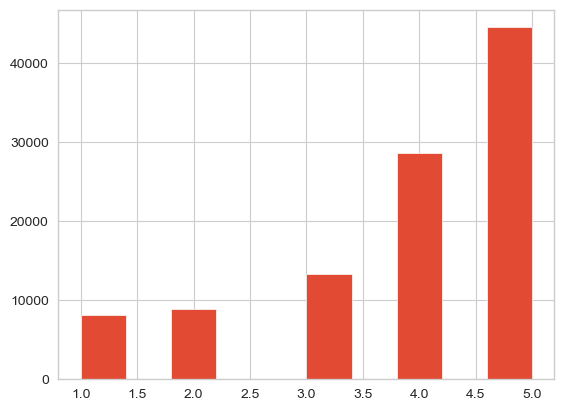

In [248]:
utility_3['review_stars'].hist()

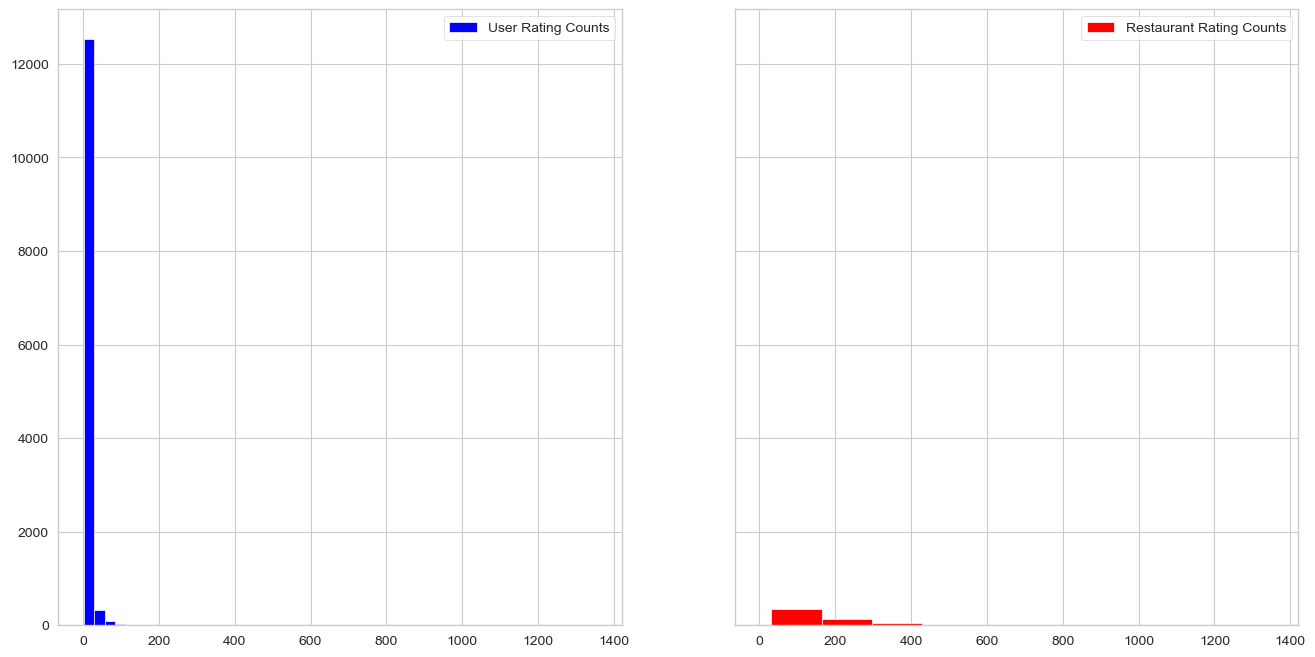

In [249]:
# Examining review distributions on the same scale
utility_user_ratings = utility_3.groupby('user_id').count()['business_id']
utility_rest_ratings = utility_3.groupby('business_id').count()['review_stars']
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True,sharex=True)
ax[0].hist(utility_user_ratings,label='User Rating Counts', color='b')
ax[1].hist(utility_rest_ratings,label='Restaurant Rating Counts', color='r')
ax[0].legend()
ax[1].legend();

In [250]:
# Max values for reviews by user and restaurant
utility_user_ratings.max(), utility_rest_ratings.max()

(277, 1354)

In [251]:
# Minimum values for reviews by user and restaurant
utility_user_ratings.min(), utility_rest_ratings.min()

(3, 32)

In [252]:
# Prepare data for models with adjusted utility matrix
reader = Reader(rating_scale=(1,5))
data_3 = Dataset.load_from_df(utility_3, reader)
trainset_3, testset_3 = train_test_split(data_3, test_size=0.2)

In [253]:
def inner_to_raw_iid_3(row):
    '''
    Returns the raw item id associated with a given Surprise inner id.
    Slightly adjusted from previous function for new trainset.
    
    Parameters:
    row: corresponds to a row in a dataframe
    
    Returns:
    output (float): raw item id
    '''
    output = trainset_3.to_raw_iid(row['iid'])
    return output

def inner_to_raw_uid_3(row):
    '''
    Returns the raw user id associated with a given Surprise inner id
    Slightly adjusted from previous function for new trainset.
    
    Parameters:
    row: corresponds to a row in a dataframe
    
    Returns:
    output (float): raw user id
    '''
    output = trainset_3.to_raw_uid(row['uid'])
    return output

In [254]:
# Place trainset/testset into dataframes
iterator_3 = trainset_3.all_ratings()
trainset_3_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in iterator_3:
    trainset_3_df.loc[i] = [uid, iid, rating]
    i = i+1

testset_3_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in testset_3:
    testset_3_df.loc[i] = [uid, iid, rating]
    i = i+1

trainset_3_df['iid'] = trainset_3_df.apply(inner_to_raw_iid_3, axis=1)
trainset_3_df['uid'] = trainset_3_df.apply(inner_to_raw_uid_3, axis=1)

In [255]:
# Number of users that are in train and not test
len(np.setdiff1d(testset_3_df['uid'].unique(), trainset_3_df['uid'].unique()))

31

In [256]:
# Number of restaurants that are in train and not test
len(np.setdiff1d(testset_3_df['iid'].unique(), trainset_3_df['iid'].unique()))

0

In [257]:
# Random ratings based on distribution of the training set
normal_predictor = NormalPredictor()
normal_predictor.fit(trainset_3)
predictions = normal_predictor.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  1.2957
1.2957325408955567
MSE: 2.7336
2.733598815654605
RMSE: 1.6534
1.6533598566720449


In [258]:
# Baseline ratings
baseline_only = BaselineOnly()
baseline_only.fit(trainset_3)
predictions = baseline_only.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

Estimating biases using als...
MAE:  0.9155
0.9154981845349297
MSE: 1.3144
1.3143879531641034
RMSE: 1.1465
1.1464675979564811


In [259]:
# NMF (defaults)
nmf = NMF()
nmf.fit(trainset_3)
predictions = nmf.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  0.9798
0.97978645047325
MSE: 1.6283
1.628256909005355
RMSE: 1.2760
1.2760317037618443


In [260]:
# Funk SVD (defaults)
svd = SVD()
svd.fit(trainset_3)
predictions = svd.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  0.9070
0.9069641996936642
MSE: 1.3161
1.3160589153607576
RMSE: 1.1472
1.1471961102447819


In [261]:
# SVD++ (defaults)
svdpp = SVDpp()
svdpp.fit(trainset_3)
predictions = svdpp.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  0.9036
0.9035843161961881
MSE: 1.3250
1.3249748887128028
RMSE: 1.1511
1.1510755356243145


In [262]:
# KNN (defaults)
knnbasic = KNNBasic()
knnbasic.fit(trainset_3)
predictions = knnbasic.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.9325
0.9325351026036794
MSE: 1.4569
1.4569190825313392
RMSE: 1.2070
1.2070290313539849


In [263]:
# KNN with means (defaults)
knnwithmeans = KNNWithMeans()
knnwithmeans.fit(trainset_3)
predictions = knnwithmeans.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.9082
0.9082201464294066
MSE: 1.4965
1.4964794754653015
RMSE: 1.2233
1.2233067789664624


In [264]:
# KNN with z-score (defaults)
knnwithzscore = KNNWithZScore()
knnwithzscore.fit(trainset_3)
predictions = knnwithzscore.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.9064
0.9064072532421761
MSE: 1.5095
1.5095436540718683
RMSE: 1.2286
1.2286348741883686


In [265]:
# Save utility matrix to text file in order to explore percentiles
utility_3.to_csv('../datasets/filter_data/utility.txt', sep='\t', header=False, index=False)

In [266]:
# NOT MY CODE - ADAPTED FROM MANSOURY ET AL'S "FLATTER IS BETTER"
# https://github.com/masoudmansoury/percentile/blob/master/percentile.py

class Percentile:
    def __init__(self):
        # self.fold = 1

        self.transformation_type = "user" # possible values: user and item
        self.percentile_position = "first" # possible values: first, floormedian, ceilmedian, last, and zscore
        self.percentile_smoothed = True # possible values: True and False
        self.percentile_smoothedparam = 5 # a paramter related to smoothing. It's an integer value and will be applied when self.smoothed is True
        self.input = "../datasets/filter_data/utility.txt"
        self.output = "../datasets/filter_data/percentile.txt"
        self.dictionary = {}
        self.rating_scale = []

    # creating user/item profile, it would be like <userid/itemid, [rate1, rate2, rate3, ...]>
    def create_profile(self):
        with open(self.input) as f:
            for line in f:
                data = line.split("\t")
                if self.transformation_type is "user":
                    per.dictionary.setdefault(data[0].rstrip(), []).append(data[2].rstrip())
                elif self.transformation_type is "item":
                    per.dictionary.setdefault(data[1].rstrip(), []).append(data[2].rstrip())

    # percentile computation for first index
    def compute_firstindex_percentile(self):
        self.delete_outputfile()
        out = open(self.output,"w")
        with open(self.input) as f:
            for line in f:
                data = line.split("\t")
                # sorting the values correspoding to the key e.g., ratings
                i = 0
                if self.transformation_type is "item":
                    i = 1
                values = sorted(map(float,list(per.dictionary.get(data[i].rstrip()))))
                # find the index of the first occurrence of repeated numbers e.g., repeated ratings
                position = values.index(float(data[2].rstrip())) + 1
                # percentile computation
                p = 0.0
                if(self.percentile_smoothed):
                    p = 100 * float(position + ((self.getRatePosition(float(data[2].rstrip())) -1 ) * self.percentile_smoothedparam)) / (len(values) + 1 + (len(self.rating_scale) * self.percentile_smoothedparam))
                else:
                    p = float(100 * position) / float(len(values) + 1)
                out.write(data[0].rstrip() + '\t' + data[1].rstrip() + '\t' + str(p) + '\n')

        out.close()

    # percentile computation for floor median index
    def compute_floormedianindex_percentile(self):
        self.delete_outputfile()
        out = open(self.output,"w")
        with open(self.input) as f:
            for line in f:
                data = line.split("\t")
                # sorting the values correspoding to the key e.g., ratings
                i = 0
                if self.transformation_type is "item":
                    i = 1
                values = sorted(map(float,list(per.dictionary.get(data[i].rstrip()))))
                # find the index of the floor median occurrence of repeated numbers e.g., repeated ratings
                last = len(values) - 1 - values[::-1].index(float(data[2].rstrip())) + 1
                first = values.index(float(data[2].rstrip())) + 1
                position = int(math.floor(float(last+first))/2)
                # percentile computation
                p = 0.0
                if(self.percentile_smoothed):
                    p = 100 * float(position + ((self.getRatePosition(float(data[2].rstrip()))-1) * self.percentile_smoothedparam) + (int(math.floor(float(self.percentile_smoothedparam/2))))) / (len(values) + 1 + (len(self.rating_scale) * self.percentile_smoothedparam))
                else:
                    p = float(100 * position) / float(len(values) + 1)
                out.write(data[0].rstrip() + '\t' + data[1].rstrip() + '\t' + str(p) + '\n')

        out.close()

    # percentile computation for ceil median index
    def compute_ceilmedianindex_percentile(self):
        self.delete_outputfile()
        out = open(self.output,"w")
        with open(self.input) as f:
            for line in f:
                data = line.split("\t")
                # sorting the values correspoding to the key e.g., ratings
                i = 0
                if self.transformation_type is "item":
                    i = 1
                values = sorted(map(float,list(per.dictionary.get(data[i].rstrip()))))
                # find the index of the ceil median occurrence of repeated numbers e.g., repeated ratings
                last = len(values) - 1 - values[::-1].index(float(data[2].rstrip())) + 2
                first = values.index(float(data[2].rstrip())) + 1
                position = int(math.ceil(float(last+first))/2)
                # percentile computation
                p = 0.0
                if(self.percentile_smoothed):
                    p = 100 * float(position + ((self.getRatePosition(float(data[2].rstrip()))-1) * self.percentile_smoothedparam) + (int(math.ceil(float(self.percentile_smoothedparam/2))))) / (len(values) + 1 + (len(self.rating_scale) * self.percentile_smoothedparam))
                else:
                    p = float(100 * position) / float(len(values) + 1)
                out.write(data[0].rstrip() + '\t' + data[1].rstrip() + '\t' + str(p) + '\n')

        out.close()

    # percentile computation for last index
    def compute_lastindex_percentile(self):
        self.delete_outputfile()
        out = open(self.output,"w")
        with open(self.input) as f:
            for line in f:
                data = line.split("\t")
                # sorting the values correspoding to the key e.g., ratings
                i = 0
                if self.transformation_type is "item":
                    i = 1
                values = sorted(map(float,list(per.dictionary.get(data[i].rstrip()))))
                # find the index of the last occurrence of repeated numbers e.g., repeated ratings
                position = len(values) - 1 - values[::-1].index(float(data[2].rstrip())) + 1
                # percentile computation
                p = 0.0
                if(self.percentile_smoothed):
                    p = 100 * float(position + (self.getRatePosition(float(data[2].rstrip())) * self.percentile_smoothedparam)) / (len(values) + 1 + (len(self.rating_scale) * self.percentile_smoothedparam))
                else:
                    p = float(100 * position) / float(len(values) + 1)
                out.write(data[0].rstrip() + '\t' + data[1].rstrip() + '\t' + str(p) + '\n')

        out.close()

    def compute_zscore(self):
        self.delete_outputfile()
        out = open(self.output,"w")
        with open(self.input) as f:
            for line in f:
                data = line.split("\t")
                # sorting the values correspoding to the key e.g., ratings
                i = 0
                if self.transformation_type is "item":
                    i = 1
                values = sorted(map(float,list(per.dictionary.get(data[i].rstrip()))))
                # compute mean of rating profile
                mean = float(sum(values)) / max(len(values),1)
                # compute standard deviation of rating profile
                nominator = 0.0
                for j in range(len(values)):
                    nominator += math.pow(float(values[j]-mean),2)
                std = math.sqrt(nominator/float(len(values)))
                # zscore computation
                z = 0.0
                if(std != 0.0):
                    z = float(float(data[2].rstrip())-mean)/std
                out.write(data[0].rstrip() + '\t' + data[1].rstrip() + '\t' + str(z) + '\n')

        out.close()

    def transform(self):
        if(self.percentile_position is "first"):
            self.compute_firstindex_percentile()
        elif (self.percentile_position is "floormedian"):
            self.compute_floormedianindex_percentile()
        elif (self.percentile_position is "ceilmedian"):
            self.compute_ceilmedianindex_percentile()
        elif (self.percentile_position is "last"):
            self.compute_lastindex_percentile()
        elif (self.percentile_position is "zscore"):
            self.compute_zscore()

    # delete output file if exists
    def delete_outputfile(self):
        try:
            if os.path.exists(self.output):
                os.remove(self.output)
        except OSError:
            print("error")
            pass

    def getRatePosition(self, rate):
        for i in range(len(self.rating_scale)):
            if rate == self.rating_scale[i]:
                return i + 1
        return 0

    def create_ratingscale(self):
        with open(self.input) as f:
            for line in f:
                rate = line.split("\t")[2]
                if(float(rate) not in self.rating_scale):
                    self.rating_scale.append(float(rate))
        self.rating_scale.sort()

<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:36: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:60: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:86: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:112: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:135: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:154: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:156: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:158: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:160: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:162: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:36: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:60: SyntaxWarning: "is" with a literal. Did you mean "=="?
<

In [267]:
# Convert utility matrix to percentile-based ratings
per = Percentile()
per.create_ratingscale()
per.create_profile()
per.transform()

In [268]:
percentile_df = pd.read_csv('../datasets/filter_data/percentile.txt',
                            sep='\t',
                            names=utility_3.columns.values)

In [269]:
percentile_df.head()

,user_id,business_id,review_stars
0,4Uh27DgGzsp6PqrH913giQ,otQS34_MymijPTdNBoBdCw,51.351351
1,4Uh27DgGzsp6PqrH913giQ,RhuYqAT45uIR2NNdDsolXQ,29.729730
2,4Uh27DgGzsp6PqrH913giQ,RhuYqAT45uIR2NNdDsolXQ,51.351351
3,4Uh27DgGzsp6PqrH913giQ,8QJTzIaR5FceGds8HBSIig,51.351351
4,4Uh27DgGzsp6PqrH913giQ,Y3ZCO17N1_T_Ms1JmswwzA,51.351351


In [270]:
percentile_df['review_stars'].min(), percentile_df['review_stars'].max()

(0.33003300330033, 94.40993788819875)

<AxesSubplot:>

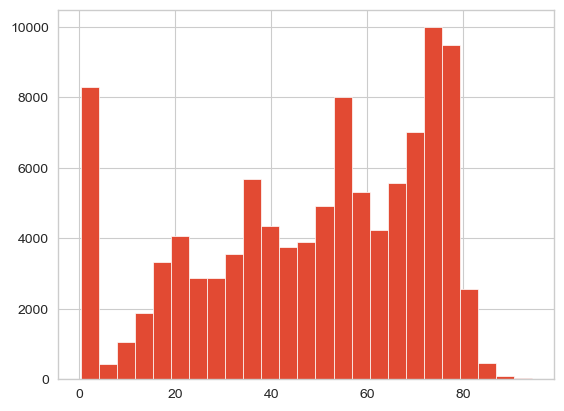

In [271]:
percentile_df['review_stars'].hist(bins=25)

In [272]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [273]:
# SVD 
svd = SVD(n_factors=20,
              n_epochs=25,
              lr_all=0.006,
              reg_all=0.08)
svdpp.fit(trainset_3)
predictions = svdpp.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  0.9053
0.9053193133210207
MSE: 1.3279
1.3278917821909437
RMSE: 1.1523
1.152341868627077


In [274]:
# Place predictions into df
predictions_df = pd.DataFrame(columns=['uid', 'iid', 'true', 'predicted'])
i = 0
for uid, iid, true_r, est, _ in predictions:
    predictions_df.loc[i] = [uid, iid, true_r, est]
    i += 1

In [275]:
predictions_df.shape

(20745, 4)

In [276]:
# Look at prediction distributions in relation to true ratings
predictions_df_1 = predictions_df[predictions_df['true'] == 1]
predictions_df_2 = predictions_df[predictions_df['true'] == 2]
predictions_df_3 = predictions_df[predictions_df['true'] == 3]
predictions_df_4 = predictions_df[predictions_df['true'] == 4]
predictions_df_5 = predictions_df[predictions_df['true'] == 5]

In [277]:
predictions_df_1['predicted'].mean(), predictions_df_1['predicted'].std()

(3.368495057621788, 0.6817585883947545)

In [278]:
predictions_df_2['predicted'].mean(), predictions_df_2['predicted'].std()

(3.5101758525508058, 0.630490317056978)

In [279]:
predictions_df_3['predicted'].mean(), predictions_df_3['predicted'].std()

(3.7033865414552034, 0.5731408752637459)

In [280]:
predictions_df_4['predicted'].mean(), predictions_df_4['predicted'].std()

(3.8825450263614005, 0.523393688198982)

In [281]:
predictions_df_5['predicted'].mean(), predictions_df_5['predicted'].std()

(4.133268068666733, 0.5082333076132018)

<AxesSubplot:>

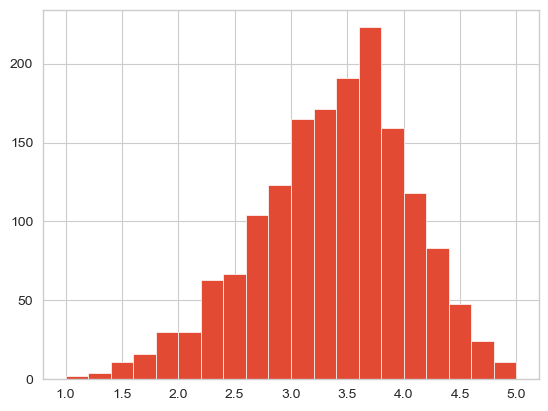

In [282]:
predictions_df_1['predicted'].hist(bins=20)

<AxesSubplot:>

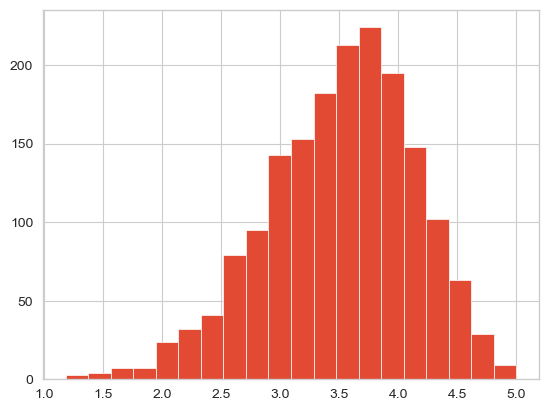

In [283]:
predictions_df_2['predicted'].hist(bins=20)

<AxesSubplot:>

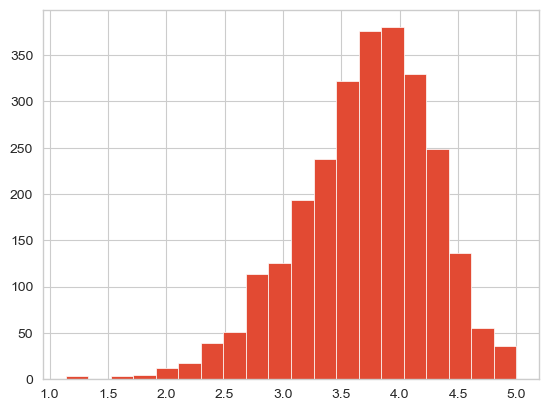

In [284]:
predictions_df_3['predicted'].hist(bins=20)

<AxesSubplot:>

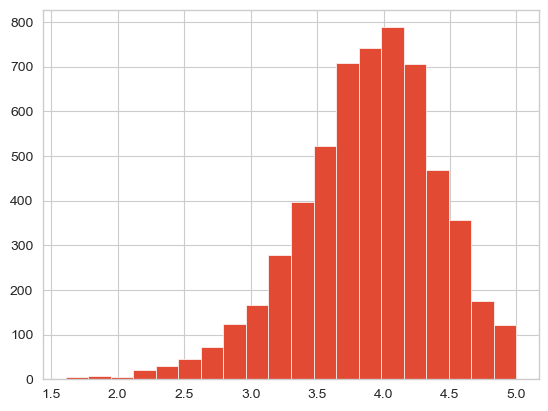

In [285]:
predictions_df_4['predicted'].hist(bins=20)

<AxesSubplot:>

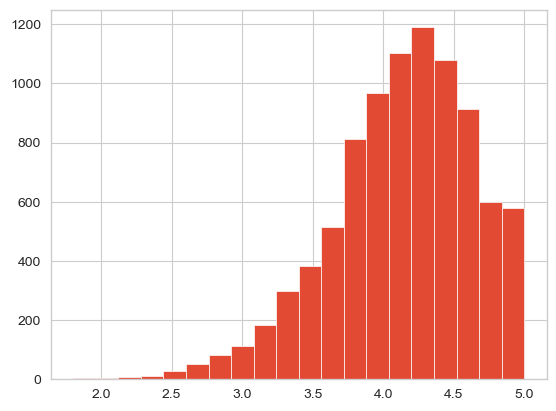

In [286]:
predictions_df_5['predicted'].hist(bins=20)

In [287]:
# Build out anti-testset in order to generate recommendations
full_trainset = data_3.build_full_trainset()
algo = SVD(n_factors=20,
             n_epochs=25,
             lr_all=0.006,
             reg_all=0.08)
algo.fit(full_trainset)
full_testset = full_trainset.build_anti_testset()
full_predictions = algo.test(full_testset)
top_n = get_top_n(full_predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [288]:
top_n['4Uh27DgGzsp6PqrH913giQ']

[('jh8j-DWqgWkbRe_a2XtKFQ', 4.727377044817604),
 ('eGi7CE2YaN6YMiGyXNi8XQ', 4.649442214044189),
 ('elP0Xn9HyP6cRBuzbJdTpw', 4.642398802972641),
 ('6OwxdpajDSJi3DkMqkr2sw', 4.6126689130788145),
 ('3qsHL1xuMPlPqQciHNYkeg', 4.581338084206804),
 ('DVBJRvnCpkqaYl6nHroaMg', 4.571035372467144),
 ('-OX0MJDPRHV0RCRvwYnvBQ', 4.515595584559981),
 ('gciMEyy9sIcwSMREEvNiXA', 4.513769707879305),
 ('ZHcfV3d7ZW8bmwgKCsz-RA', 4.50377181584189),
 ('CJoO4HYD0tZRXlZqA04wmw', 4.502039561666783)]

In [289]:
utility_3[utility_3['user_id'] == '4Uh27DgGzsp6PqrH913giQ']

,user_id,business_id,review_stars
0,4Uh27DgGzsp6PqrH913giQ,otQS34_MymijPTdNBoBdCw,4
1,4Uh27DgGzsp6PqrH913giQ,RhuYqAT45uIR2NNdDsolXQ,3
2,4Uh27DgGzsp6PqrH913giQ,RhuYqAT45uIR2NNdDsolXQ,4
3,4Uh27DgGzsp6PqrH913giQ,8QJTzIaR5FceGds8HBSIig,4
4,4Uh27DgGzsp6PqrH913giQ,Y3ZCO17N1_T_Ms1JmswwzA,4
5,4Uh27DgGzsp6PqrH913giQ,E3QSrua1cXWaurPitBhKGQ,4
6,4Uh27DgGzsp6PqrH913giQ,0bLvKEwQaFYovyfpZ0HdJA,3
7,4Uh27DgGzsp6PqrH913giQ,IKMAgK2m6WRIViVFB2vAFQ,4
8,4Uh27DgGzsp6PqrH913giQ,E2l9h35n-BpwWpV5RVye-w,5
9,4Uh27DgGzsp6PqrH913giQ,BTblqXsOHMXjcgcYkdzuqg,4


In [290]:
def find_and_compare(user_id, top_n):
    '''
    Returns the raw user id associated with a given Surprise inner id

    Arguments:
    user_id (string): user_id string
    top_n (dict): top_n dictionary generated from get_top_n

    Returns:
    reviewed_businesses_df (dataframe): dataframe of businesses reviewed by
    the given user
    recommended_df (dataframe): dataframe of recommended restaurants
    '''
    reviewed_df = utility_3[utility_3['user_id'] == user_id]
    merged_reviewed_df = reviewed_df.merge(right=business_df,
                                           how='left',
                                           left_on='business_id',
                                           right_on='business_id')
    reviewed_businesses_df = merged_reviewed_df[['business_name',
                                                 'review_stars',
                                                 'categories']]

    top_n_df = pd.DataFrame(columns=['business_id', 'predicted'])
    i = 0
    for business, predicted in top_n[user_id]:
        top_n_df.loc[i] = [business, predicted]
        i += 1
    top_n_businesses_df = top_n_df.merge(right=business_df,
                                         how='left',
                                         left_on='business_id',
                                         right_on='business_id')
    recommended_df = top_n_businesses_df[['business_name',
                                          'predicted',
                                          'categories']]

    return reviewed_businesses_df, recommended_df

In [291]:
# Average number of reviews left by a user
utility_3['user_id'].value_counts().mean()

7.970032272936837

In [292]:
# Compare/contrast recommended restaurants and actual reviews provided
actual_df, recommended_df = find_and_compare('4Uh27DgGzsp6PqrH913giQ', top_n)

In [293]:
actual_df

,business_name,review_stars,categories
0,BK Tacos,4,"Restaurants, Tacos, Mexican, Hot Dogs, Breakfa..."
1,St Mary's Mexican Food,3,"Restaurants, Mexican"
2,St Mary's Mexican Food,4,"Restaurants, Mexican"
3,Barrio Brewing,4,"Nightlife, Sports Bars, Bars, Breweries, Pubs,..."
4,Taqueria Pico De Gallo,4,"Mexican, Restaurants"
5,El Sur Restaurant,4,"Restaurants, Mexican, Comfort Food, New Mexica..."
6,Five Guys,3,"Restaurants, Burgers, American (New), Fast Food"
7,Miss Saigon,4,"Vegetarian, Vietnamese, Restaurants, Noodles"
8,Lee Lee International Supermarkets,5,"Ethnic Grocery, Food, Ethnic Food, Grocery, Sp..."
9,47 Scott,4,"Restaurants, Nightlife, Breakfast & Brunch, Am..."


In [294]:
recommended_df

,business_name,predicted,categories
0,Barrio Bread,4.727377,"Food, Specialty Food, Bakeries, Restaurants"
1,Spice Garden Indian Cuisine,4.649442,"Restaurants, Indian, Vegetarian"
2,Urban Fresh,4.642399,"Vegan, Live/Raw Food, Food, Juice Bars & Smoot..."
3,Barista Del Barrio,4.612669,"Restaurants, Food, Breakfast & Brunch, Coffee ..."
4,Anello,4.581338,"Pizza, Restaurants"
5,Tumerico,4.571035,"Mexican, Gluten-Free, Vegetarian, Restaurants,..."
6,NI HAO TEA,4.515596,"Tea Rooms, Restaurants, Vegan, Bubble Tea, Foo..."
7,Roma Imports,4.513770,"Cheese Shops, Delis, Specialty Food, Restauran..."
8,Pizza Luna,4.503772,"Salad, Restaurants, Pizza"
9,Crave Coffee Bar,4.502040,"Food, Coffee & Tea, Restaurants"


In [295]:
def get_user_totals(uid):
    '''
    Returns the number of items rated by given user
    
    Arguments: 
    uid (string): the id of the user
    
    Returns: 
    (int): the number of items rated by the user
    '''
    try:
        return len(trainset_3.ur[trainset_3.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_item_totals(iid):
    '''
    Returns the number of users that have rated a given item
    
    Arguments:
    iid (string): the raw id of the item
      
    Returns:
    (int): the number of users that have rated the item.
    '''
    try: 
        return len(trainset_3.ir[trainset_3.to_inner_iid(iid)])
    except ValueError:
        return 0

In [296]:
# Generate the best/worst predictions by absolute error
predictions_df['user_totals'] = predictions_df['uid'].apply(get_user_totals)
predictions_df['item_totals'] = predictions_df['iid'].apply(get_item_totals)
predictions_df['err'] = abs(predictions_df['predicted'] -
                            predictions_df['true'])
best_predictions = predictions_df.sort_values(by='err')[:50]
worst_predictions = predictions_df.sort_values(by='err')[-50:]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0, 0, '1'),
 Text(1, 0, '2'),
 Text(2, 0, '3'),
 Text(3, 0, '4'),
 Text(4, 0, '5')]

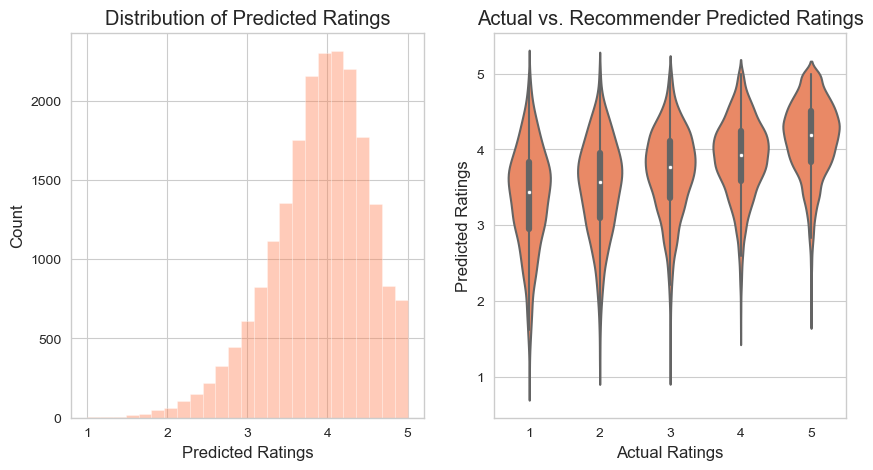

In [297]:
# Plot prediction distributions via histogram & violin plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.distplot(predictions_df['predicted'], bins=25, norm_hist=False,
             color='coral', ax=axs[0], kde=False)
axs[0].set_title('Distribution of Predicted Ratings')
axs[0].set_xlabel('Predicted Ratings')
axs[0].set_ylabel('Count')

pred_data = ([predictions_df['predicted'][predictions_df['true'] == rating]
              .values for rating in range(1, 6)])
sns.violinplot(data=pred_data, ax=axs[1], color='coral')
axs[1].set_title('Actual vs. Recommender Predicted Ratings')
axs[1].set_xlabel('Actual Ratings')
axs[1].set_ylabel('Predicted Ratings')
axs[1].set_xticklabels(np.arange(1,6))


In [298]:
best_predictions

,uid,iid,true,predicted,user_totals,item_totals,err
12218,1h40OGNNcZ0nrrdJh4PEww,Tj-sKlbJR5M7Rpe9Cykk9w,5.0,5.0,15,251,0.0
466,GvLB4-XP2yeQELVW2F_7pw,LRr-aw58xVMkUu0OSL_BpQ,5.0,5.0,4,201,0.0
17817,aHiQYaTXrmQTeG6106l5wg,ZYxGiEyHD17kd80zUzaOQA,5.0,5.0,94,214,0.0
8491,hj4mHoNIFUnZV11dLMMfTw,j8feOxyJqlIJWOi8su2qzw,5.0,5.0,23,519,0.0
17837,lb6GPCR-ecVuOC57TIgYNg,LmZWlvPJBwj5WG2KHV-v1Q,5.0,5.0,17,340,0.0
17854,-6ULgMBfzqbgOPcE5PrRWQ,K6ORcbEU1vpC0E7F3qes3Q,5.0,5.0,25,89,0.0
8381,YYxpnIDbdRmc3AFesUcOPA,QO4E57PptMqNMrSS9sefUw,5.0,5.0,9,149,0.0
8353,o_tZOSJl0qCHGKHCWrg_-A,Ei5HBqe012ImhqEr2ZH2gg,5.0,5.0,7,198,0.0
17883,es1aTwAQpxxf9dUP_bGGIQ,XYFu64UPMMfoOlGTz3J4fw,1.0,1.0,9,52,0.0
1854,EOSSBrLfVE07nIv-WcalwA,rLMRRaLhgxH2cU2XuJf_BQ,5.0,5.0,6,266,0.0


In [299]:
worst_predictions

,uid,iid,true,predicted,user_totals,item_totals,err
13381,Z_FzGGu5vggFwelcMy17oA,Ei5HBqe012ImhqEr2ZH2gg,1.0,4.517224,2,198,3.517224
1346,4b2rcgbPMsYm785lV28H3A,wj8XtPyuREj8_0GQz3LZ6w,1.0,4.520401,8,480,3.520401
1191,kDBTf_z0-xVm7MfWZ8OVJg,3cyjdxvskRcADylzLI32cQ,1.0,4.524068,14,106,3.524068
12650,zMgwLH29hbo-p1n2e-THNA,Tj-sKlbJR5M7Rpe9Cykk9w,1.0,4.525381,4,251,3.525381
13499,aSpI5FySfpU4vR1NKNsvIQ,uSIGgRScZmpWlEcHtoaWlA,1.0,4.528758,7,403,3.528758
1562,-CJuOmq1GYYgndjqncSF3g,QMo3URjgmyY_jU9GtYfxtA,1.0,4.535424,2,109,3.535424
13636,PM7Y1hRf00UicxpP8Rb6tQ,YSRM9nWQn40eg49tSiI-_Q,1.0,4.535901,3,355,3.535901
17407,TBUk--BjeXPESdZM5PXx8g,EmBa8UWYRwM_3hagkqwtIg,1.0,4.542688,23,253,3.542688
10992,-bHnkg9mGmFk3xJNW1uDsQ,3XRHR2IZ7yd3FDAogps20A,1.0,4.550711,4,84,3.550711
13262,Y3aSrTddfpfErLKuqneo-g,MfkMUNwur9huBERrx0k5lg,1.0,4.553928,2,203,3.553928


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Counts (Log)')

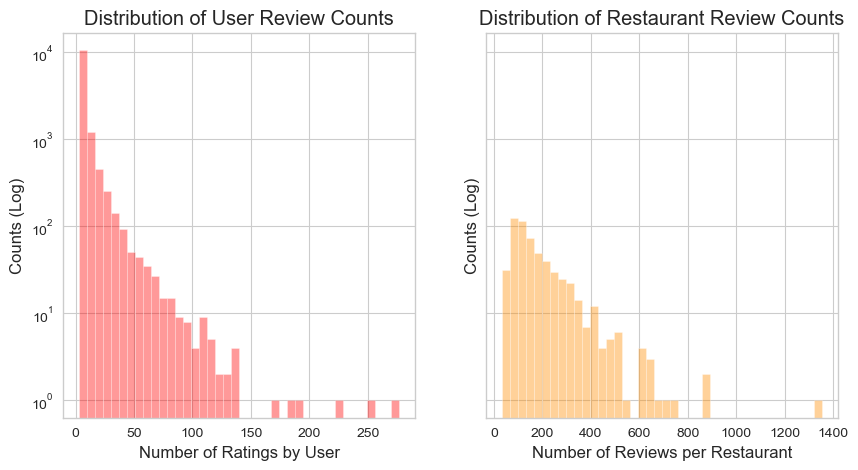

In [300]:
# Plots of user/restaurant review counts
fig, axs = plt.subplots(1,2,figsize=(10,5), sharey=True)

sns.distplot(utility_user_ratings, kde=False, color='red', norm_hist=False,
             ax=axs[0], bins=40)
axs[0].set_title('Distribution of User Review Counts')
axs[0].set_yscale('log')
axs[0].set_xlabel('Number of Ratings by User')
axs[0].set_ylabel('Counts (Log)')

sns.distplot(utility_rest_ratings, color='darkorange', norm_hist=False,
             kde=False, ax=axs[1], bins=40)
axs[1].set_yscale('log')
axs[1].set_title('Distribution of Restaurant Review Counts')
axs[1].set_xlabel('Number of Reviews per Restaurant')
axs[1].set_ylabel('Counts (Log)')



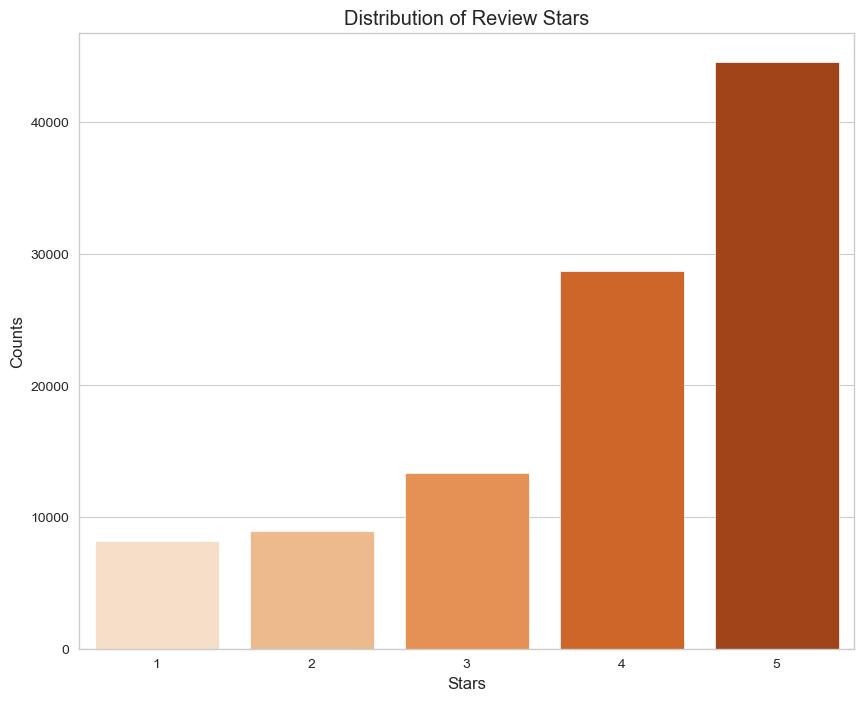

In [301]:
# Bar plot of counts of review stars
fig, ax = plt.subplots(figsize=(10, 8))
utility_review_stars = (utility_3['review_stars']
                        .value_counts(ascending=True))
sns.barplot(x='index', y='review_stars',
            data=utility_review_stars.reset_index(), palette='Oranges',
            ax=ax)
ax.set_title('Distribution of Review Stars')
ax.set_xlabel('Stars')
ax.set_ylabel('Counts')

fig.savefig('reviewcounts.png')

In [302]:
# The following cells evaluate predictions on a user by user basis
# Looking to see how error changes depending on presence in testset
predictions_df[predictions_df['uid'] == '4Uh27DgGzsp6PqrH913giQ']

,uid,iid,true,predicted,user_totals,item_totals,err
12018,4Uh27DgGzsp6PqrH913giQ,BTblqXsOHMXjcgcYkdzuqg,4.0,3.996422,10,282,0.003578


In [303]:
calc_rmse = predictions_df[predictions_df['uid'] == '4Uh27DgGzsp6PqrH913giQ']
predictions_df[predictions_df['uid'] == '4Uh27DgGzsp6PqrH913giQ']

,uid,iid,true,predicted,user_totals,item_totals,err
12018,4Uh27DgGzsp6PqrH913giQ,BTblqXsOHMXjcgcYkdzuqg,4.0,3.996422,10,282,0.003578


In [304]:
predictions_df[predictions_df['uid'] == '4Uh27DgGzsp6PqrH913giQ'].shape

(1, 7)

In [305]:
predictions_df[predictions_df['uid'] == '4Uh27DgGzsp6PqrH913giQ']['err'].mean()

0.003578407049049215

In [306]:
((calc_rmse.true - calc_rmse.predicted) ** 2).mean() ** .5

0.003578407049049215

In [307]:
user_df[user_df['user_id'] == '4Uh27DgGzsp6PqrH913giQ']

,user_id,user_name,review_count,yelping_since,average_stars
74,4Uh27DgGzsp6PqrH913giQ,Goldie,50,2009-09-29 22:24:04,4.27


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


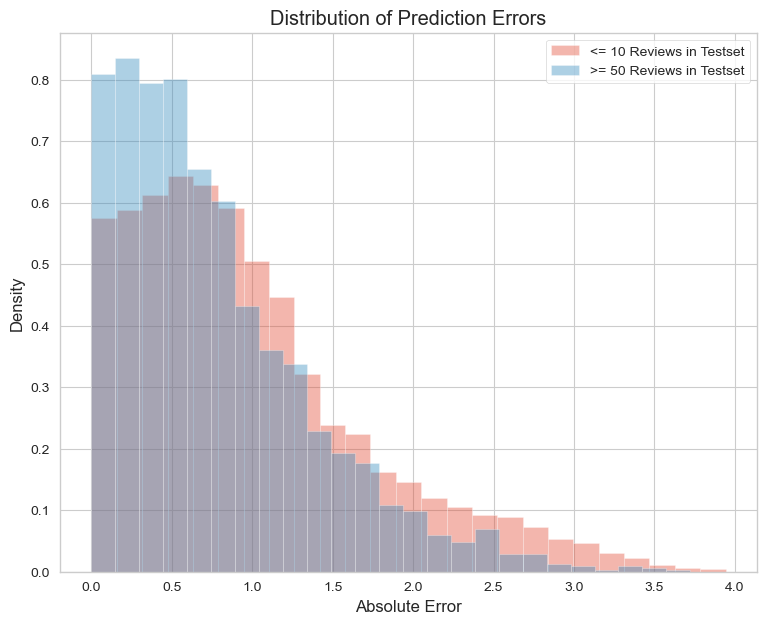

In [308]:
fig, ax = plt.subplots(figsize=(9,7))
user_under = predictions_df[predictions_df['user_totals'] <= 10]
user_over = predictions_df[predictions_df['user_totals'] >= 50]
sns.distplot(user_under['err'], label='<= 10 Reviews in Testset',
             bins=25, ax=ax, norm_hist=True, kde=False)
sns.distplot(user_over['err'], label='>= 50 Reviews in Testset',
             bins=25, ax=ax, norm_hist=True, kde=False)
ax.set_title('Distribution of Prediction Errors')
ax.set_xlabel('Absolute Error')
ax.set_ylabel('Density')
ax.legend()


(0.0, 1.03)

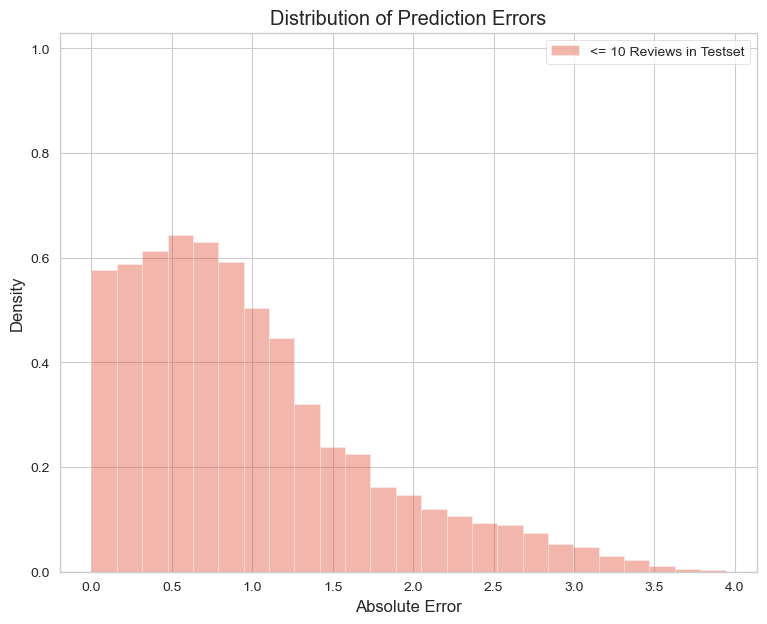

In [309]:
fig, ax = plt.subplots(figsize=(9,7))
sns.distplot(user_under['err'], label='<= 10 Reviews in Testset',
             bins=25, ax=ax, norm_hist=True, kde=False)
ax.set_title('Distribution of Prediction Errors')
ax.set_xlabel('Absolute Error')
ax.set_ylabel('Density')
ax.legend()
ax.set_ylim(0, 1.03)